In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mat = loadmat('../references/AAL78/C78.mat')


In [23]:
C = mat['C']
C.shape
alpha = 0.2
C = alpha * C / np.max(C)

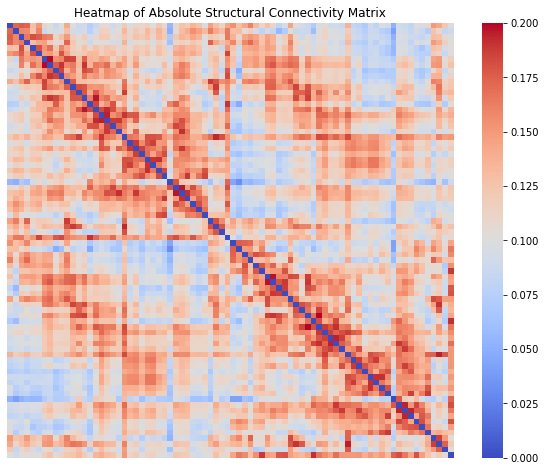

In [4]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))  # Set the figure size for better visibility
sns.heatmap(C, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Absolute Structural Connectivity Matrix')
plt.show()

### Landau-Stuart Oscillator model and Plot for ORBinf.L and IPL.L

In [39]:
def solve_ode_network(num_steps, dt, a, omega, beta, C, G=0.5, seed=42):
    # Initialize the arrays to store the x, y values for all neurons
    np.random.seed(seed)
    x_values = np.zeros((num_steps, 78))
    y_values = np.zeros((num_steps, 78))
    
    # Initialize x and y vectors with zeros
    x = np.ones(78)*0.5
    y = np.ones(78)*0.5

    # Pre-generate noise for all neurons and all time steps
    noise = np.random.randn(num_steps, 78) * np.sqrt(dt)

    for step in range(num_steps):
        # Generate a single random noise term for each neuron
        # Extract the noise for the current step
        current_noise = noise[step, :]


        # Calculate the dxdt and dydt using the equations provided
        dxdt = (a - x**2 - y**2)*x - omega*y + G * np.dot(C, (x - x[:, None]).T).diagonal() 
        dydt = (a - x**2 - y**2)*y + omega*x + G * np.dot(C, (y - y[:, None]).T).diagonal() 
        
        # Update the x and y values
        x += dxdt * dt + beta * current_noise
        y += dydt * dt + beta * current_noise
        
        # Store the values
        x_values[step, :] = x
        y_values[step, :] = y

    
    return x_values, y_values

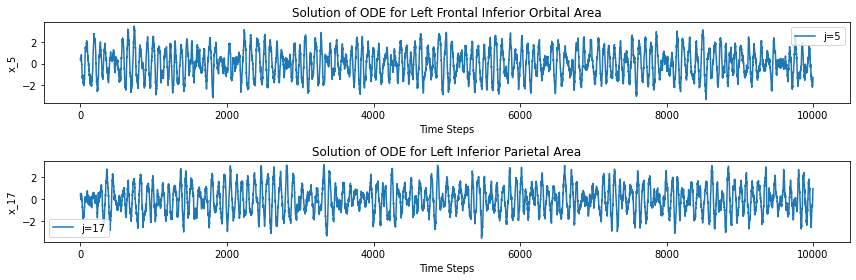

In [44]:
# Example usage:
num_steps = 10000  # for example
dt = 0.001  # time step
a = 0.0  # intrinsic dynamics parameters for each neuron
omega = 2 * np.pi * 12  # angular frequencies for each neuron
beta = 5  # noise level

# Solve the ODEs
x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C)

f = 12

region_names = {5: 'Left Frontal Inferior Orbital Area', 17: 'Left Inferior Parietal Area'}
j = np.array([5, 17])
fig, axes = plt.subplots(len(j), 1, figsize=(12, len(j)*2))

for i, region_index in enumerate(j):
    region_name = region_names.get(region_index, f'Region {region_index}')
    axes[i].plot(x_values[:, region_index], label=f'j={region_index}')
    axes[i].set_xlabel('Time Steps')
    axes[i].set_ylabel(f'x_{region_index}')
    axes[i].set_title(f'Solution of ODE for {region_name}')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Wilson-Cowan network and Plot for two regions

In [ ]:
def wc_ode_network(p_i, num_steps, dt, beta, C, G=0.5, seed=42):

    tau_e = 3
    tau_i = 8
    w_ee = 10
    w_ei = 12
    w_ii = 10
    w_ie = 10
    p_e = 0

    total_nodes = C.shape[0]

    np.random.seed(seed)
    e_values = np.zeros((num_steps, total_nodes))
    i_values = np.zeros((num_steps, total_nodes))

    e = np.ones(total_nodes)*0.5
    i = np.ones(total_nodes)*0.5

    f_a = lambda x: 1 / (1 + np.exp(-x))

    # Pre-generate noise for all neurons and all time steps
    noise = np.random.randn(num_steps, total_nodes) * np.sqrt(dt)
    
    for step in range(num_steps):

        current_noise = noise[step, :]

        coupling = G*(np.sum(C, axis=1))

        dedt = (-e + f_a(w_ee*e - w_ei*i + p_e + coupling))/tau_e
        didt = (-i + f_a(w_ie*e - w_ii*i + p_i))/tau_i

        e += dedt * dt + beta * current_noise
        i += didt * dt + beta * current_noise

        e_values[step, :] = e
        i_values[step, :] = i
    return e_values, i_values

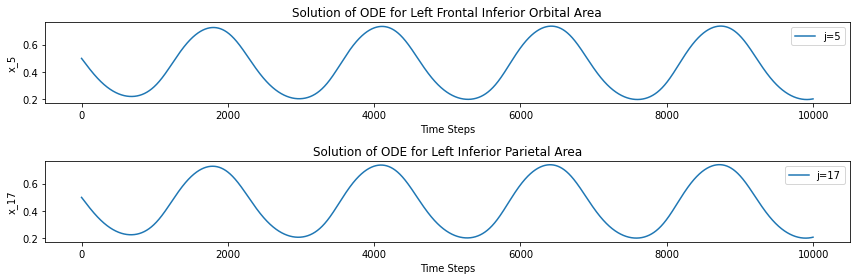

In [58]:
# Example usage:
num_steps = 10000  # for example
dt = 0.01  # time step
pi = -1  # intrinsic dynamics parameters for each neuron
beta = 0  # noise level

# Solve the Wilson-Cowan ODEs
e_values, i_values = wc_ode_network(pi, num_steps, dt, beta, C, G=0.01)

region_names = {5: 'Left Frontal Inferior Orbital Area', 17: 'Left Inferior Parietal Area'}
j = np.array([5, 17])
fig, axes = plt.subplots(len(j), 1, figsize=(12, len(j)*2))

for i, region_index in enumerate(j):
    region_name = region_names.get(region_index, f'Region {region_index}')
    axes[i].plot(e_values[:, region_index], label=f'j={region_index}')
    axes[i].set_xlabel('Time Steps')
    axes[i].set_ylabel(f'x_{region_index}')
    axes[i].set_title(f'Solution of ODE for {region_name}')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Plotting for frequencies 4:28:4

In [8]:
def plot_signals_for_frequencies(num_steps, dt, a, beta, C, G=0.5):
    frequencies = range(4, 30, 4)  # From 4 to 28, step by 4
    num_frequencies = len(frequencies)
    time = np.arange(0, num_steps * dt, dt)  # Time array
    
    # Creating subplots for each frequency
    fig, axs = plt.subplots(num_frequencies, 1, figsize=(10, 2 * num_frequencies), sharex=True)

    # Adding a main title to the figure
    fig.suptitle(f'X Values for G={G}, Beta={beta}, Frequencies {frequencies[0]}-{frequencies[-1]} Hz', fontsize=16)
    
    for i, f in enumerate(frequencies):
        omega = 2 * np.pi * f  # Angular frequency
        x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)
        
        ax = axs[i] if num_frequencies > 1 else axs
        ax.plot(time, x_values[:, 0])
        ax.set_title(f'{f} Hz')
        ax.set_ylabel('X value')
    
    axs[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    
    # Saving the figure with G, beta, and frequency range in the filename
    # filename = f'../Plots/python_plots/carrier_frequency_plots/x_values_G{G}_beta{beta}_freq{frequencies[0]}-{frequencies[-1]}.png'
    # plt.savefig(filename)
    # print(f'Saved: {filename}')

Saved: ../Plots/python_plots/carrier_frequency_plots/x_values_G0.5_beta5_freq4-28.png


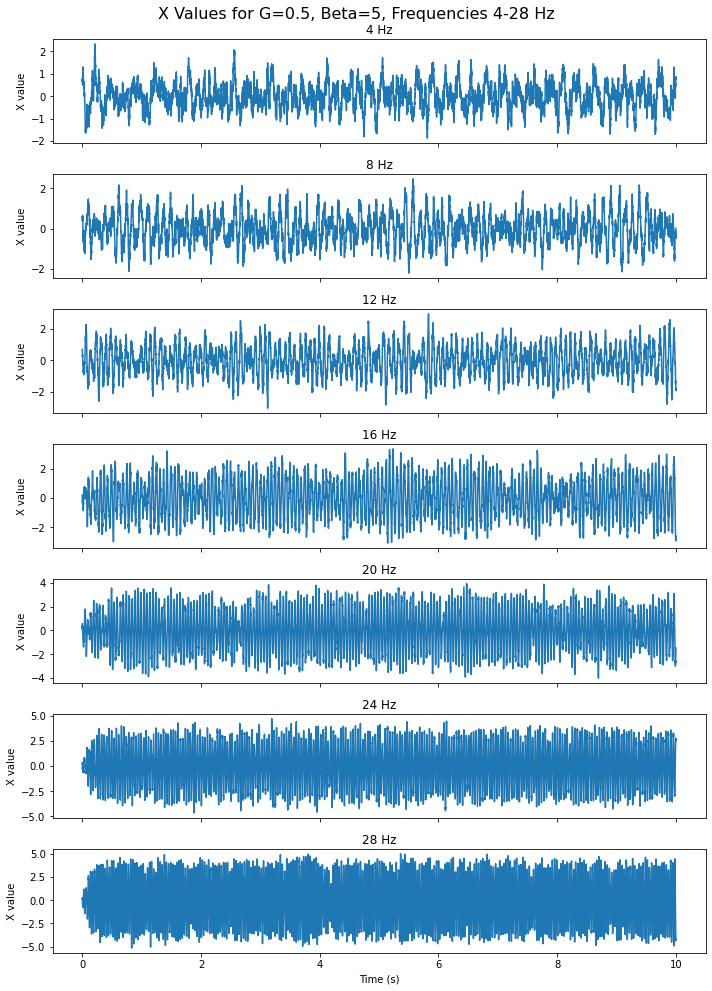

In [9]:
plot_signals_for_frequencies(10000, 0.001, 0.0, 5, C, 0.5)